<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, SOUL, and VI to the Bayesian latent space network model from Hoff et al. (2002). 

# Latent space network model - Game of Thrones

First, we load the modules that we will need:

In [1]:
import os
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import procrustes

# Numpy for computations.
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)

# Pyplot for plots.
import matplotlib.pyplot as plt 

This dataset contains interactions between Games of Thrones characters during the first 4 seasons of the TV show. An edge exists between characters if they have interacted (i.e. spoken) with one another during that season of the show.

In [2]:
from load_got import load_got

# Load GoT character interaction networks
Y, names = load_got(seasons=[1,2,3,4], weight_min=10)
y = jnp.asarray(Y[0])

#Remove the rows and columns which contain only zero entries, i.e. degree=0
names = names[np.where(np.sum(y,1)!=0)[0]]
ytemp = np.delete(y,np.where(np.sum(y,1)==0),0)
y = np.delete(ytemp,np.where(np.sum(ytemp,0)==0),1)


The data we model consist of an $D \times D$ matrix Y, with each entry $y_{i,j}$ denoting the value of the relation from node $i$ to node $j$. We focus on binary-valued relations, although this could be extended to more general relations, e.g. count data or weighted networks. These extensions to more general relations are essentially alternative generalised linear models. Both directed and undirected relations can be analysed with the following model.

We take a conditional independence approach to modeling by assuming that the presence or absence of a tie between two individuals (i.e. nodes) is independent of all other ties in the system, given the unobserved positions in social space of the two individuals,

$P(Y|X,\theta) = \prod_{i \neq j} P(y_{i,j}|x_{i,j},\theta)$.

A convenient model for $P(y_{i,j}|x_{i,j},\theta)$ is the logistic regression model, where the probability of a tie between nodes $i$ and $j$ depends on the Euclidean distance between $x_i$ and $x_j$,

$\eta_{i,j} = \mbox{log-odds}(y_{i,j}=1|x_i, x_j, \theta) = \alpha - ||x_i-x_j||.$

In [3]:
#log-target density p_theta(y,x)
def log_target(th, z):
    dist = jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1)+10e-6)
    eta = th - dist
    log_prior =  -jnp.sum(jnp.dot(z.T,z))  
    log_lik = jnp.sum(jnp.multiply(y,eta) - jnp.log1p(jnp.exp(eta)))
    return log_lik + log_prior

We then implement the algorithms. They take the following inputs:

*   y : D x D adjacency matrix,
*   h : step size parameter 
*   K : number of steps,
*   N : number of particles,
*   th : 1-dimensional vector with parameter guess,
*   X : D x N matrix storing the initial particle cloud.

The following inference algorithms return the following outputs:

*   th : K-dimensional vector of parameter estimates,
*   X : [D, 2, N]) matrix storing the particle clouds, assuming a 2-dimensional latent space.

In [4]:
# Algorithms.

#Particle gradient descent
def pgd(y, h, K, N, th, X):
    D = X[:,:,0].shape  # Extract latent variable dimension.
    
    for k in range(K):
        #Update particle cloud:
        Xkp1 = np.copy(X)
        gx = [grad_x(th[k],X[:,:,i]) for i in range(N)]
        for i in range(N):
            Xkp1[:,:,i] =  X[:,:,i] + h*gx[i] + np.sqrt(2*h)*np.random.normal(0, 1, D)
        X = np.copy(Xkp1)
        th = np.append(th, th[k] + h*np.mean([grad_theta(th[k],X[:,:,i]) for i in range(N)]))  # Update theta.
    return th, X

#Coin version of the PGD function
def coin(y, K, N, th, X):
    theta0 = np.copy(th)
    x_shape = X.shape
    X0 = X.reshape(-1,X.shape[-1])

    # initialise other vars for X and theta
    L_theta, L_X = 0, 0
    grad_theta_sum, grad_Xk_sum = 0, 0
    reward_theta, reward_X = 0, 0
    abs_grad_theta_sum, abs_grad_Xk_sum = 0, 0
    for k in range(K):
        Xk = X.reshape(-1,X.shape[-1])  # Extract current particle cloud.
        # Update particle cloud:
        
        # calculate kernel matrix
        kxy, dx_kxy = svgd_kernel(Xk, h=-1)

        # gradient
        gx = [grad_x(th[k],X[:,:,i]).flatten() for i in range(N)]
        grad_Xk = (np.matmul(kxy, np.asarray(gx).T) + dx_kxy) 

        # |gradient|
        abs_grad_Xk = abs(grad_Xk)

        # constant
        L_X = np.maximum(abs_grad_Xk, L_X)

        # sum of gradients
        grad_Xk_sum += grad_Xk
        abs_grad_Xk_sum += abs_grad_Xk

        # 'reward'
        reward_X = np.maximum(reward_X + np.multiply(Xk - X0, grad_Xk), 0)

        # X update
        Xkp1 = X0 + grad_Xk_sum / (L_X * (abs_grad_Xk_sum + L_X)) * (L_X + reward_X)
        
        X = Xkp1.reshape(x_shape)
        
        # Update theta:
        # gradient
        grad_th = np.mean([grad_theta(th[k],X[:,:,i]) for i in range(N)]) 

        # |gradient|
        abs_grad_theta = abs(grad_th)

        # constant
        L_theta = np.maximum(abs_grad_theta, L_theta)

        # sum of gradients
        grad_theta_sum += grad_th
        abs_grad_theta_sum += abs_grad_theta

        # 'reward'
        reward_theta = np.maximum(reward_theta + np.multiply(th[k] - theta0, grad_th), 0)

        # theta update
        th = np.append(th, theta0 + grad_theta_sum / (L_theta * (abs_grad_theta_sum + L_theta)) * (L_theta + reward_theta))  # Update theta.
    return th, X



# Auxiliary functions.

def svgd_kernel(theta, h = -1):
    sq_dist = pdist(theta)
    pairwise_dists = squareform(sq_dist) ** 2

    # if h < 0, using median trick
    if h < 0:
        h = np.median(pairwise_dists)
        h = np.sqrt(0.5 * h / np.log(theta.shape[0] + 1))

    # rbf kernel
    kxy = np.exp(-pairwise_dists / h ** 2 / 2)

    # rbf kernel grad
    dx_kxy = -np.matmul(kxy, theta)
    sum_kxy = np.sum(kxy, axis=1)

    for i in range(theta.shape[1]):
        dx_kxy[:, i] = dx_kxy[:, i] + np.multiply(theta[:, i], sum_kxy)

    dx_kxy = dx_kxy / (h ** 2)

    return kxy, dx_kxy

def procrustes_transform(X, mle):
    Xtrans = np.copy(X)
    for i in range(N):
        _, Xtrans[:,:,i], _ = procrustes(mle, X[:,:,i])    
    return Xtrans
 
grad_theta = grad(log_target, 0)
grad_x = grad(log_target,1)

## Run the inference algorithms to learn $\theta$ and the latent positions of the network nodes $X$. 

We start by running a simple gradient descent algorithm to find the maximum likelihood estimate for $\theta$ and $X$.

In [5]:
#Find the MLE
D = y.shape[0]

# Initialize parameter estimates and particle cloud, all at zero:
key, x_key = random.split(key, 2)
th = jnp.array([[1.0]])  # Parameter estimate.
x = 0.1*random.normal(x_key,(D, 2))

lr = 0.01
for step in range(10000):
    x_grad = grad_x(th,x)
    x += lr*x_grad
    th_grad = grad_theta(th,x) 
    th += lr*th_grad
    if step % 1000 == 0:
        print('Log_target', log_target(th,x))
        print('theta',th)

#Because reflections, rotations and translations of X will lead to the same likelihood value, so use a procrustean transformation X to a reference set X0.
Xmle, _ ,_ = procrustes(random.normal(x_key,(D, 2)), x)  

Log_target -8337.58
theta [[-23.521992]]
Log_target -1037.1521
theta [[0.5081508]]
Log_target -1017.299
theta [[0.54920363]]
Log_target -997.162
theta [[0.5106404]]
Log_target -994.0451
theta [[0.5112715]]
Log_target -995.43243
theta [[0.5218425]]
Log_target -996.57794
theta [[0.52819824]]
Log_target -993.20905
theta [[0.51969147]]
Log_target -993.12787
theta [[0.5210941]]
Log_target -993.2415
theta [[0.52264214]]


In [6]:
# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 500  # Number of steps.
N = 10  # Number of particles.
D = y.shape[0]

# Initialize parameter estimates and particle cloud, all at zero:
th0 = th  # Parameter estimate.
key, x_key = random.split(key, 2)
X0 = 0.01*random.normal(x_key,(D, 2, N))
for i in range(N):
    X0.at[:,:,i].set(X0[:,:,i]+Xmle)

# Run algorithms:
#th_vi, X_vi, m_vi, s_vi = vi(ltrain, ftrain, h, K, N, th0, X0)
th_pgd, X_pgd = pgd(y, h, K, N, th0, X0)
th_coin, X_coin = coin(y, K, N, th0, X0)
  
#Procrustes transformation - post-processing step
X_pgd = procrustes_transform(X_pgd, Xmle)
X_coin = procrustes_transform(X_coin, Xmle)

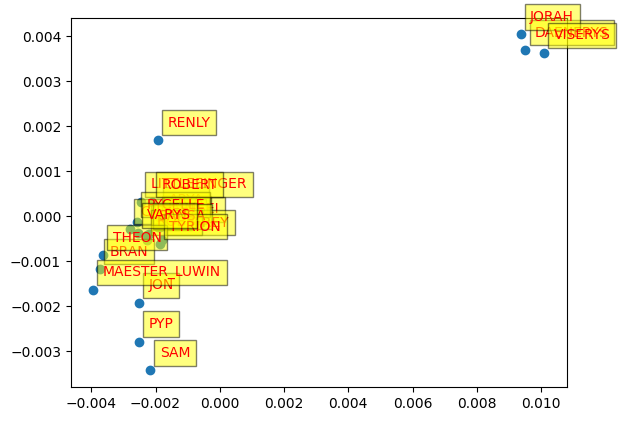

In [7]:
#Plot the latent positions
import pandas as pd

avg_X_coin = jnp.mean(X_coin,axis=2)
avg_X_pgd = jnp.mean(X_pgd,axis=2)

indx = jnp.sum(y,1)>4
plotting_index = np.where(indx*np.arange(D)!=0)[0]

plt.scatter(avg_X_coin[plotting_index,0],avg_X_coin[plotting_index,1])

for i in plotting_index:
    jitter = 0.0003#*np.random.randn()
    plt.text(x=avg_X_coin[i,0]+jitter,y=avg_X_coin[i,1]+jitter,s=names[i],fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))

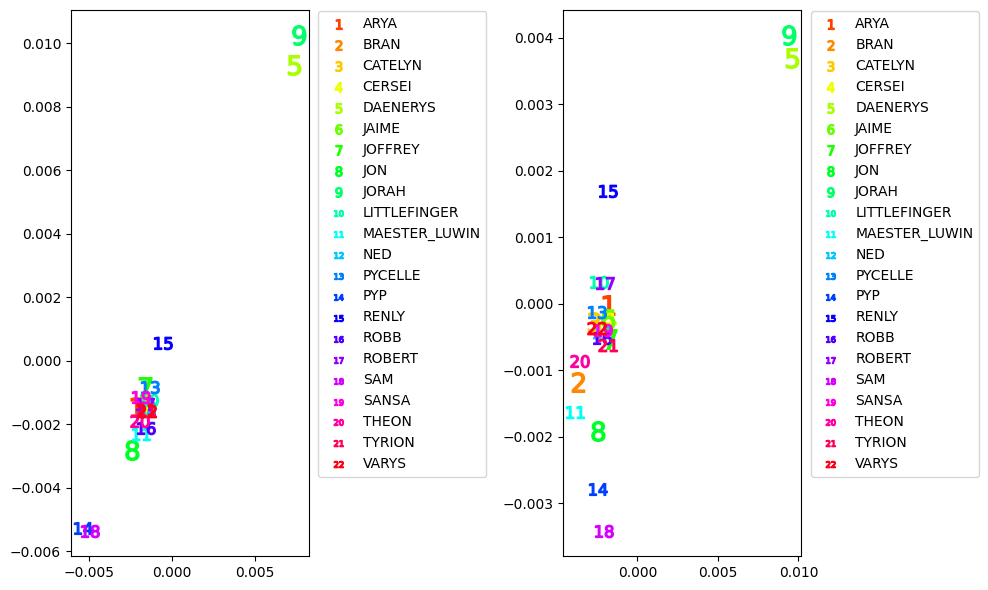

In [8]:
#Alternative plotting

n = np.arange(1, len(plotting_index))
x_y_colours = plt.get_cmap('hsv')(n / n.max())
x_y_labels = names[plotting_index]

fig, ax = plt.subplots(1,2,figsize=(10,6))
for xi, yi, color_i, label_i, txt in zip(avg_X_pgd[plotting_index,0], avg_X_pgd[plotting_index,1], x_y_colours, x_y_labels, n):
    ax[0].scatter(xi, yi, marker=f'${txt}$', s=200, color=color_i, label=label_i)
ax[0].legend(markerscale=0.5, bbox_to_anchor=[1.01, 1.01], loc='upper left')
for xi, yi, color_i, label_i, txt in zip(avg_X_coin[plotting_index,0], avg_X_coin[plotting_index,1], x_y_colours, x_y_labels, n):
    ax[1].scatter(xi, yi, marker=f'${txt}$', s=200, color=color_i, label=label_i)
ax[1].legend(markerscale=0.5, bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.tight_layout()
plt.show()

And plot the parameter estimate $\theta$ as a function of k:

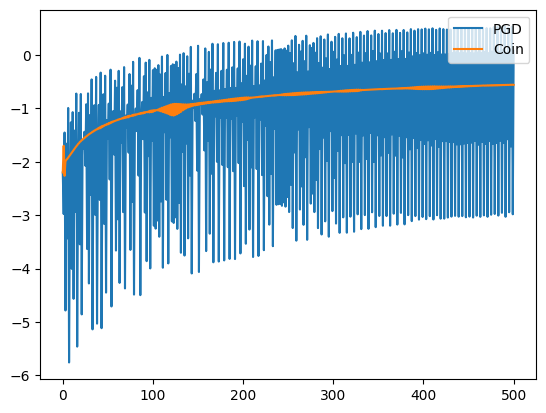

In [9]:
#plt.plot(th_vi, label='VI')
plt.plot(th_pgd, label='PGD')
#plt.xlim([-K/100, K])
plt.plot(th_coin, label='Coin')
plt.legend(loc='upper right')